# Dataset overview
Sephora dataset contains customer reviews and product metadata for its products. Each row represents a review linked to a product via 'product_id'

In [ ]:
import pandas as pd

# loading the preprocessed data script
from src.data_preprocessing import load_processedDfs
df = load_processedDfs()

In [57]:
print('Shape of the dataset',df.shape)
print('Review submission time span\n',df[['submission_time']].agg(['min','max']))
print('Total products and reviews counts\n',df[['product_id','author_id']].nunique())

Shape of the dataset (1100554, 39)
Review submission time span
     submission_time
min      2008-08-28
max      2023-03-21
Total products and reviews counts
 product_id      8494
author_id     578653
dtype: int64


Analysis: 
The dataset consists of 1.1 M total rows with 8494 unique products and 578,653 reviews.
- The reviews spans from 2008 to 2023
- Key product attributes include brand, price, primary and secondary categories, limited_edition
- Key reviews attributes include rating, is_recommended, helpfulness, total_feedback_count, review text and title

This structure enables both 'product level analysis' and 'review level analysis'

## What products do customer love the most?
To analyze this two metrics were used:
(i) products love count to show customer appreciation and 
(ii) maximum number of reviews for each product as a proxy for sales volume

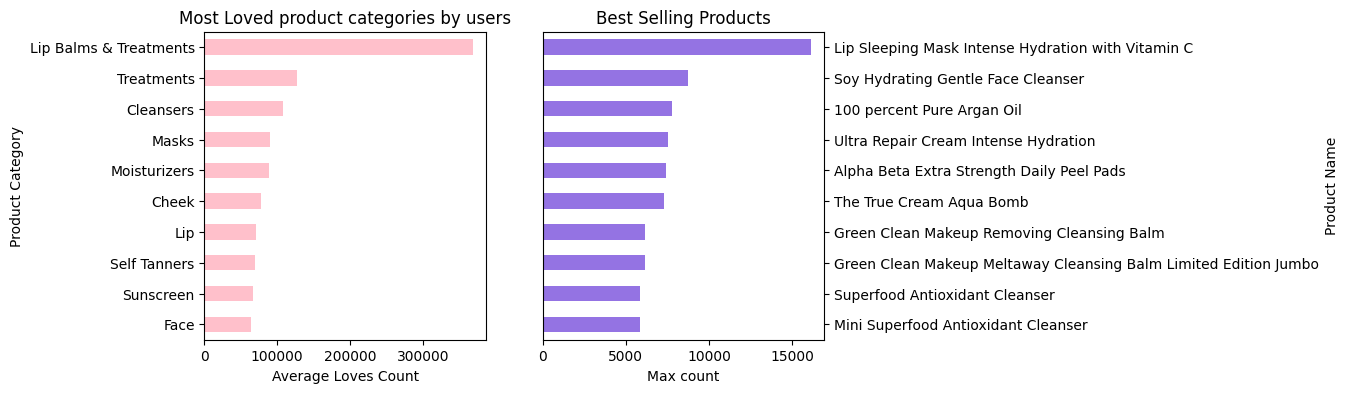

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
# most loved products (products that are marked favourite by users)
df.groupby('secondary_category')['loves_count'].mean().sort_values(ascending=False).head(10).plot(kind='barh',color='pink')
plt.ylabel('Product Category')
plt.xlabel('Average Loves Count')
plt.gca().invert_yaxis()
plt.title('Most Loved product categories by users')

# best selling products
plt.subplot(1,2,2)
df[(df['is_recommended']==1)&(df['product_rating']>4)].groupby('product_name')['reviews'].max().sort_values(ascending=False).head(10).plot(kind='barh',color='#9473E3')
plt.xlabel('Max count')
plt.ylabel('Product Name')
plt.title('Best Selling Products')
plt.gca().yaxis.set_label_position('right')
plt.gca().yaxis.tick_right()
plt.gca().invert_yaxis()
plt.show()


Analysis: Lip balms, cleansers products emerge as the most loved products indicating strong customer preferance for everyday skincare essentials. Notably, 'Lip sleeping mask' is the best selling product by maximum reviews which aligns closely with their high love counts. This consistency across both metrics suggests that customer affection translates into sustained engagement and repeat purchases within this category

## Do products sells differntly in online and offline stores?
To analyze this, products were filtered and counted over online_only flag

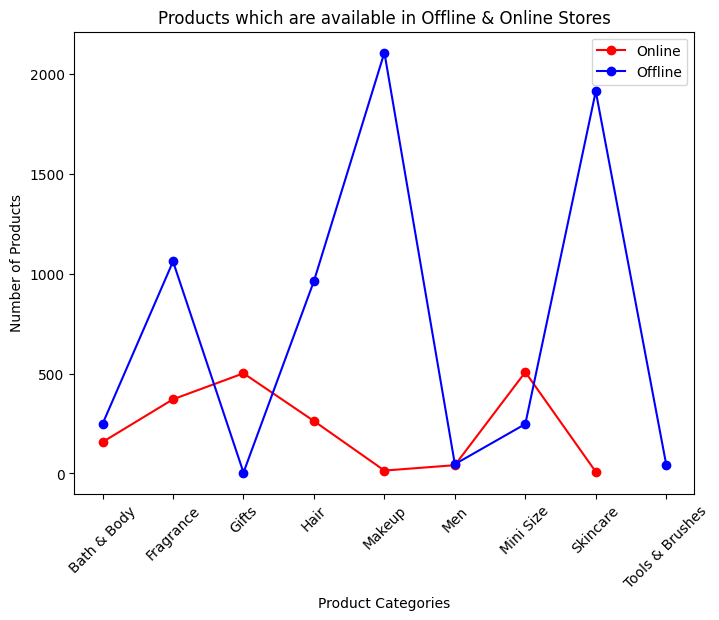

In [66]:
plt.figure(figsize=(8,6))

# number of products in primary category that are available in offline and online stores
df_products_only = df.groupby('product_id').first().reset_index()
filtered_online = df_products_only[(df_products_only['online_only'] == 1)]
filtered_offline = df_products_only[(df_products_only['online_only'] == 0)]
# Count number of products per primary_category
category_counts_online = filtered_online['primary_category'].value_counts().sort_index()
category_counts_offline = filtered_offline['primary_category'].value_counts().sort_index()
# Plot
category_counts_online.plot(kind='line',color='red',label='Online',marker='o')
category_counts_offline.plot(kind='line',color='blue',label='Offline',marker='o')
plt.xlabel('Product Categories')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.title('Products which are available in Offline & Online Stores')
plt.legend(loc='best')
plt.show()

Analysis: Offline stores dominates sales for makeup and skincare products, likely due to the need for physical testing and personalization evaluation. But gift items show higher online sales, reflecting custoemr preferance for convenience and promotion pricing or discount when product fit is less critical.

## How are Sephora products priced and how popular brands position themselves within that price range?
To understand this, products overall price distribution is examined and how brands place their prices within this range

Maximum price among all products 1900.0
Average price for all products 51.66


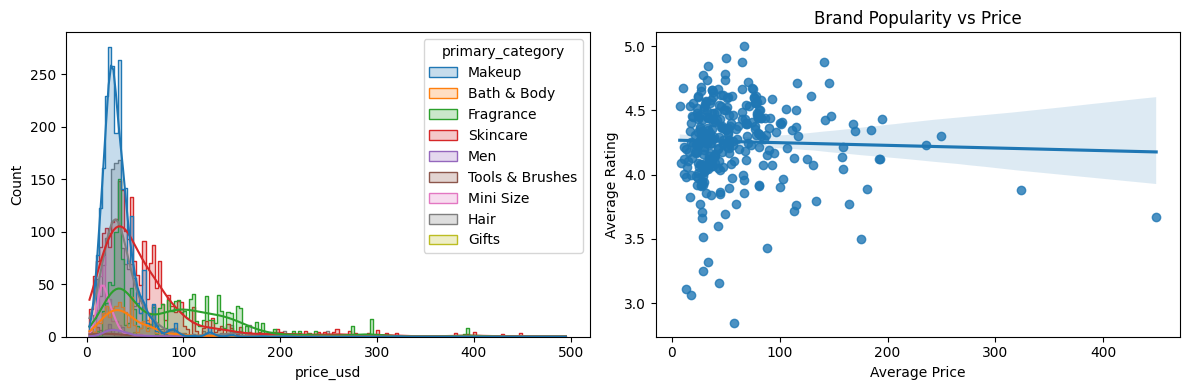

In [60]:
import seaborn as sns

# checking for any outliers
max_price = df_products_only['price_usd'].max()
print('Maximum price among all products',max_price)
avg_price = df_products_only['price_usd'].mean()
print('Average price for all products',round(avg_price,2))

# considering max_price as outlier, so removing that row from the df
df2 = df_products_only[df_products_only['price_usd']!=max_price]

# Price distribution among primary category products
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df2,x="price_usd",hue="primary_category",element="step",kde=True)  # Adding a KDE curve for smoother visualization

# Brand popularity vs price
plt.subplot(1, 2, 2)
brands = df.groupby('brand_name')[['price_usd', 'product_rating', 'reviews']].mean().sort_values(by='product_rating', ascending=False).reset_index()
sns.regplot(x='price_usd', y='product_rating', data=brands)
plt.xlabel('Average Price')
plt.ylabel('Average Rating')
plt.title('Brand Popularity vs Price')

plt.tight_layout()

plt.show()


Analysis: After removing extreme outlier ($1900), the average product price is approximately $51.66. The price distribution is heavily left-skewed with majority of products priced between $0 - $100. This range accounts for the highest concenteration of makeup products which sells the most. 

Brand level price positioning further reinforces this pattern with most brands clustering their average product prices between $0 to $100 and only small amount exceeding $200. This suggests that Sephora's catalog is largely focussed on accessible pricing serving core market

## How do ratings evolve over time?
To analyze this, review submission time was plotted against total number of ratings for each year.

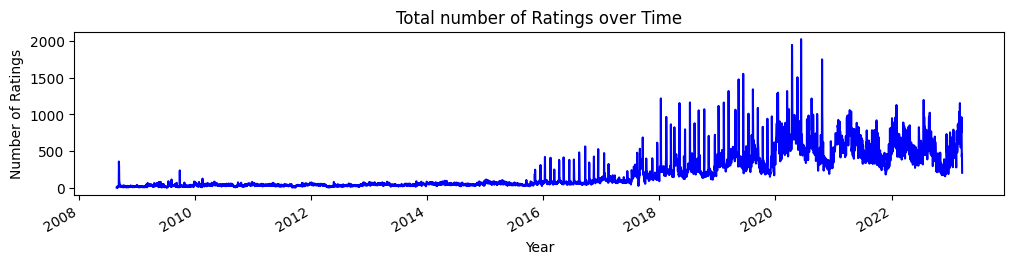

In [65]:
plt.figure(figsize=(12,6))

# total number of ratings after 2019
plt.subplot(2,1,2)
df.groupby('submission_time')['product_rating'].count().plot(kind='line',color='blue')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.title('Total number of Ratings over Time')
plt.subplots_adjust(hspace=0.5)

plt.show()

Analysis : Product engagement shows a steady increase after 2016 as Sephora  expanded market presence and reaches its peak in 2020. This surge likely reflect a shift towards incresed online shopping during covid times. Following 2020 engagement experiences has faced a mild decline but overall activity remains high.

## How does customer engagement change over time?
To demonstrate this, total feedback count was calculated against each year and helpfulness 

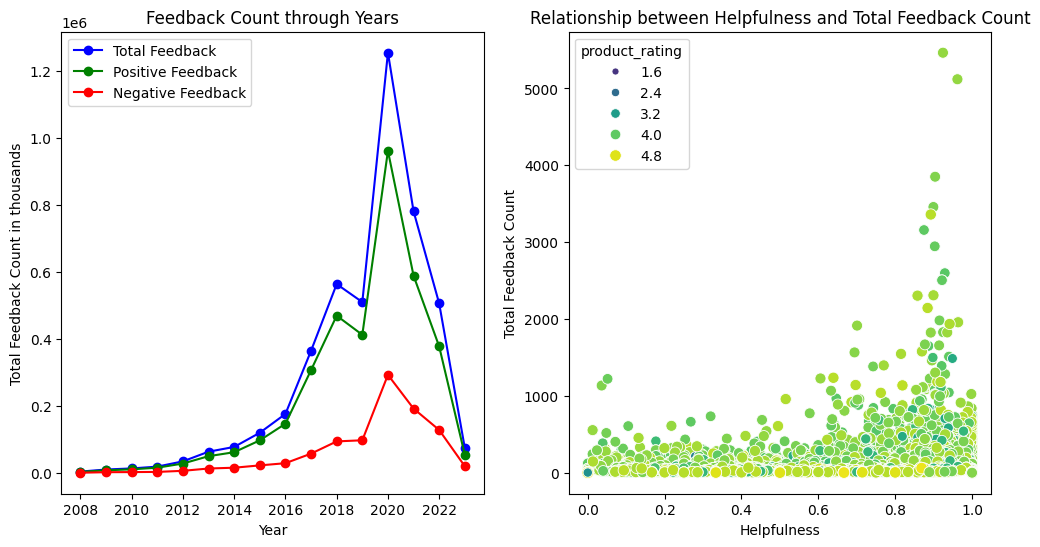

In [ ]:
# converting submission time to datetime format
df['submission_time'] = pd.to_datetime(df['submission_time'])

# extracting year from the merged df
df['submission_year'] = df['submission_time'].dt.year

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
df.groupby('submission_year')['total_feedback_count'].sum().plot(kind='line',color='blue',label='Total Feedback',marker='o')
df.groupby('submission_year')['total_pos_feedback_count'].sum().plot(kind='line',color='green',label='Positive Feedback',marker='o')
df.groupby('submission_year')['total_neg_feedback_count'].sum().plot(kind='line',color='red',label='Negative Feedback',marker='o')
plt.xlabel('Year')
plt.ylabel('Total Feedback Count in thousands')
plt.title('Feedback Count through Years')
plt.legend(loc='best')

# relationship between helpfulness and total feedback count
plt.subplot(1,2,2)
sns.scatterplot(data=df,x='helpfulness',y='total_feedback_count',size='product_rating',hue='product_rating',palette='viridis')
plt.xlabel('Helpfulness')
plt.ylabel('Total Feedback Count')
plt.title('Relationship between Helpfulness and Total Feedback Count')

plt.show()

Analysis: Customers review volume increased over the years but peaked in the year 2020 during covid times when the online shopping reached its peak so more room to review the product. While customers found rating more helpful in buying products